#### Optimal Portfolio & Simulation

In [9]:
#ND: To Fix Error - ModuleNotFoundError: No module named 'yfinance', 
#DID NOT WORKED- I installed Python, Started Cmd prompt with run as administration and run 'python -m pip install yfinance', it installed library but still did not worked as installed in different python version
#Worked way to to install yfinance directly from anaconda prompt to python 3, using commands 'conda activate base', 'pip install yfinance'

import numpy as np
import pandas as pd
import yfinance as yf
import scipy.optimize as sco
import matplotlib.pyplot as plt

# Step 1: Download historical data
tickers = ["C", "V", "NFLX", "KO", "XOM"] #['IAU', 'VDE', 'XLB', 'DBC', 'CQQQ']
data = yf.download(tickers, start="2021-01-03", end="2024-09-30")['Adj Close']
#from = '2021-01-03', to = '2024-09-30',

# Step 2: Calculate daily returns
returns = data.pct_change().dropna()

# Step 3: Define the portfolio optimization functions

# Function to calculate portfolio volatility
def portfolio_volatility(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

#ND: # Constraints: All weights sum to 1, each weight >= 1%, and each weight <= 40%
def min_volatility_portfolio(cov_matrix):
    num_assets = len(cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},
                   {'type': 'ineq', 'fun': lambda weights: weights - 0.01}  # Minimum weight constraint of 1% instead of old 5%
                  ,{'type': 'ineq', 'fun': lambda weights: 0.40 - weights})   # Maximum weight constraint of 40% instead of old 100%
    bounds = tuple((0.01, 0.40) for _ in range(num_assets))  # Set min and max weights #ND- update from tuple((0.05, 1) to tuple((0.01, 0.40)
    initial_guess = np.ones(num_assets) / num_assets  # Equal distribution as initial guess
    
    
    # Optimization
    result = sco.minimize(portfolio_volatility, initial_guess, args=(cov_matrix,),
                          method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

# Calculate covariance matrix and mean returns
cov_matrix = returns.cov()
mean_returns = returns.mean()

# Get optimized weights for minimum volatility portfolio
optimal_weights = min_volatility_portfolio(cov_matrix)
print("Optimized Weights:", optimal_weights)

#ND- Added Code to Calculate average return and variance
average_returns = mean_returns.dot(optimal_weights)
portfolio_variance = portfolio_volatility(optimal_weights, cov_matrix) ** 2  # Squaring volatility to get variance

print("\nAverage Portfolio Return:", average_returns)
print("Portfolio Variance:", portfolio_variance)

[*********************100%***********************]  5 of 5 completed

Optimized Weights: [0.09318054 0.4        0.04729866 0.26574961 0.19377119]

Average Portfolio Return: 0.0006434071215760158
Portfolio Variance: 8.972473075708727e-05


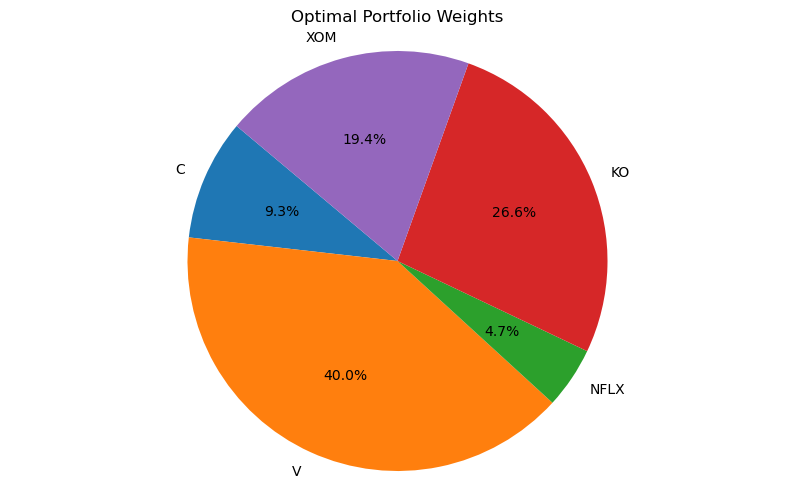

In [2]:
# (a) Provide a pie chart with optimal portfolio weights
labels = tickers
plt.figure(figsize=(10, 6))
plt.pie(optimal_weights, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Optimal Portfolio Weights')
plt.axis('equal')  # Equal aspect ratio ensures that pie chart is circular
plt.show()

[*********************100%***********************]  5 of 5 completed


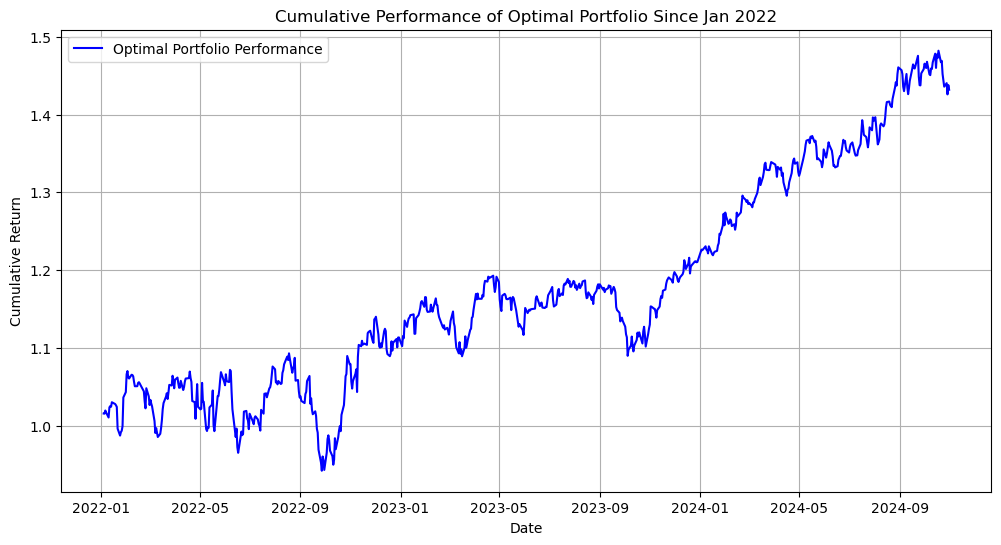

Cumulative Return: 0.43185374577614644
Annualized Return: 0.1356780219917011
Annualized Volatility: 0.1507181399905449


In [3]:


# (b) Show the performance of the optimal portfolio since Jan-2022
# Download data for the optimal portfolio
portfolio_data = yf.download(tickers, start="2022-01-01", end="2024-11-01")['Adj Close']

# Calculate the portfolio returns
portfolio_returns = (portfolio_data.pct_change().dropna() * optimal_weights).sum(axis=1)

# Calculate performance statistics
cumulative_return = (1 + portfolio_returns).prod() - 1
annualized_return = ((1 + cumulative_return) ** (252 / len(portfolio_returns))) - 1
annualized_volatility = portfolio_returns.std() * np.sqrt(252)

# Create a time-series chart of portfolio performance
cumulative_performance = (1 + portfolio_returns).cumprod()

plt.figure(figsize=(12, 6))
plt.plot(cumulative_performance, label='Optimal Portfolio Performance', color='blue')
plt.title('Cumulative Performance of Optimal Portfolio Since Jan 2022')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid()
plt.show()

# Print performance statistics
print("Cumulative Return:", cumulative_return)
print("Annualized Return:", annualized_return)
print("Annualized Volatility:", annualized_volatility)

[*********************100%***********************]  1 of 1 completed


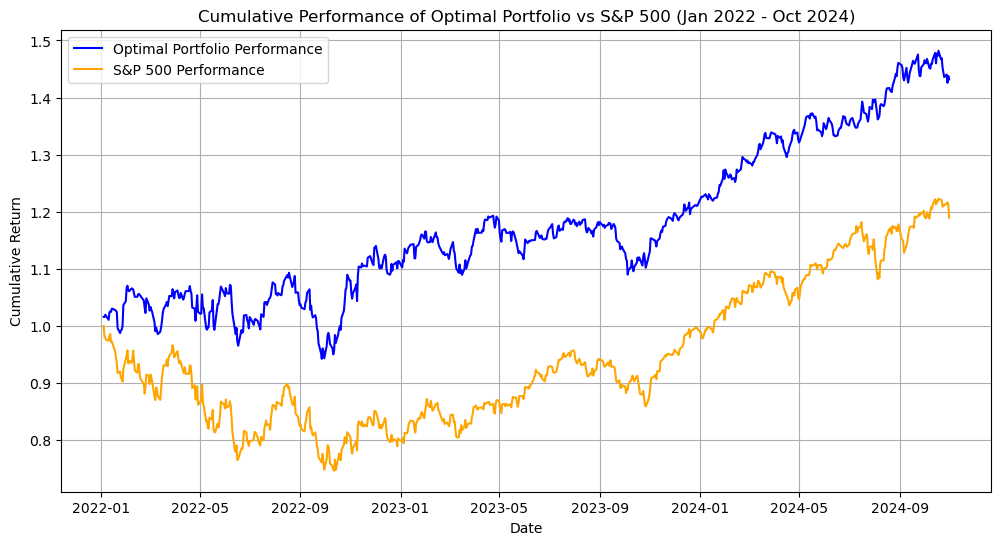

Optimal Portfolio Cumulative Return: 0.43185374577614644
S&P 500 Cumulative Return: Ticker
^GSPC    0.189488
Name: 2024-10-31 00:00:00+00:00, dtype: float64
Optimal Portfolio Annualized Return: 0.1356780219917011
S&P 500 Annualized Return: Ticker
^GSPC    0.063432
Name: 2024-10-31 00:00:00+00:00, dtype: float64
Optimal Portfolio Annualized Volatility: 0.1507181399905449
S&P 500 Annualized Volatility: Ticker
^GSPC    0.177097
dtype: float64


In [4]:

# (c) Show actual portfolio performance relative to S&P 500 over Jan-2022 to Oct-2024 period
# Download S&P 500 data
sp500_data = yf.download('^GSPC', start="2022-01-01", end="2024-11-01")['Adj Close']

# Calculate the portfolio returns as before
portfolio_returns = (portfolio_data.pct_change().dropna() * optimal_weights).sum(axis=1)

# Create a cumulative performance series for both the portfolio and S&P 500
cumulative_portfolio = (1 + portfolio_returns).cumprod()
cumulative_sp500 = (1 + sp500_data.pct_change().dropna()).cumprod()

# Create a time-series chart to compare performance
plt.figure(figsize=(12, 6))
plt.plot(cumulative_portfolio, label='Optimal Portfolio Performance', color='blue')
plt.plot(cumulative_sp500, label='S&P 500 Performance', color='orange')
plt.title('Cumulative Performance of Optimal Portfolio vs S&P 500 (Jan 2022 - Oct 2024)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid()
plt.show()

# Performance statistics
cumulative_return_portfolio = cumulative_portfolio.iloc[-1] - 1
cumulative_return_sp500 = cumulative_sp500.iloc[-1] - 1

annualized_return_portfolio = ((1 + cumulative_return_portfolio) ** (252 / len(portfolio_returns))) - 1
annualized_return_sp500 = ((1 + cumulative_return_sp500) ** (252 / len(sp500_data.pct_change().dropna()))) - 1

annualized_volatility_portfolio = portfolio_returns.std() * np.sqrt(252)
annualized_volatility_sp500 = sp500_data.pct_change().std() * np.sqrt(252)

# Print performance statistics
print("Optimal Portfolio Cumulative Return:", cumulative_return_portfolio)
print("S&P 500 Cumulative Return:", cumulative_return_sp500)
print("Optimal Portfolio Annualized Return:", annualized_return_portfolio)
print("S&P 500 Annualized Return:", annualized_return_sp500)
print("Optimal Portfolio Annualized Volatility:", annualized_volatility_portfolio)
print("S&P 500 Annualized Volatility:", annualized_volatility_sp500)



[*********************100%***********************]  5 of 5 completed


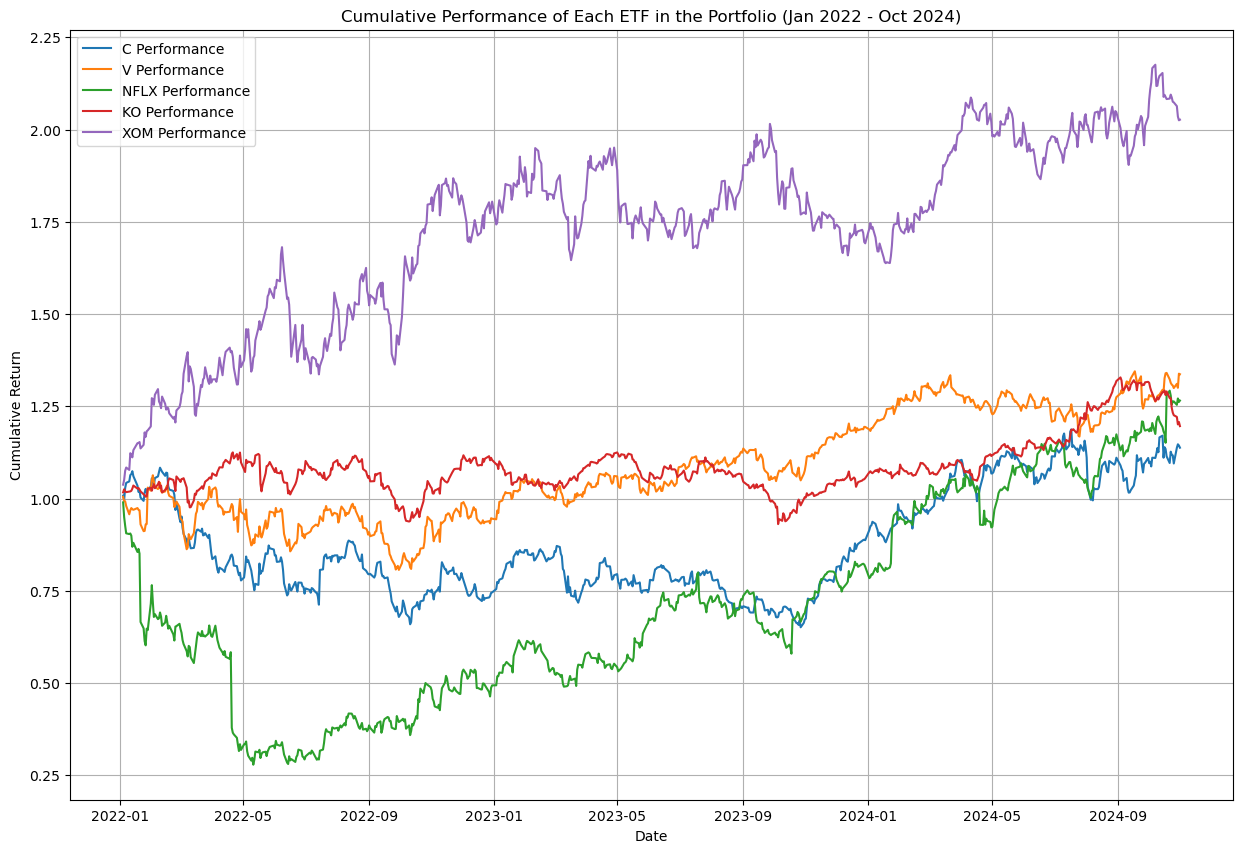

Performance Statistics for C:
  Cumulative Return: 13.78%
  Annualized Return: 4.68%
  Annualized Volatility: 28.62%

Performance Statistics for V:
  Cumulative Return: 33.70%
  Annualized Return: 10.84%
  Annualized Volatility: 22.45%

Performance Statistics for NFLX:
  Cumulative Return: 26.56%
  Annualized Return: 8.71%
  Annualized Volatility: 50.10%

Performance Statistics for KO:
  Cumulative Return: 19.64%
  Annualized Return: 6.56%
  Annualized Volatility: 15.71%

Performance Statistics for XOM:
  Cumulative Return: 102.68%
  Annualized Return: 28.45%
  Annualized Volatility: 27.66%



In [5]:


# Download historical data for each ETF
etf_data = yf.download(tickers, start="2022-01-01", end="2024-11-01")['Adj Close']

# Calculate daily returns for each ETF
etf_returns = etf_data.pct_change().dropna()

# Create a time-series chart for each ETF's performance
plt.figure(figsize=(15, 10))

for ticker in tickers:
    cumulative_returns = (1 + etf_returns[ticker]).cumprod()
    plt.plot(cumulative_returns, label=f'{ticker} Performance')

plt.title('Cumulative Performance of Each ETF in the Portfolio (Jan 2022 - Oct 2024)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid()
plt.show()

# Performance statistics for each ETF
for ticker in tickers:
    cumulative_return = (1 + etf_returns[ticker]).cumprod().iloc[-1] - 1
    annualized_return = ((1 + cumulative_return) ** (252 / len(etf_returns))) - 1
    annualized_volatility = etf_returns[ticker].std() * np.sqrt(252)

    print(f"Performance Statistics for {ticker}:")
    print(f"  Cumulative Return: {cumulative_return:.2%}")
    print(f"  Annualized Return: {annualized_return:.2%}")
    print(f"  Annualized Volatility: {annualized_volatility:.2%}\n")

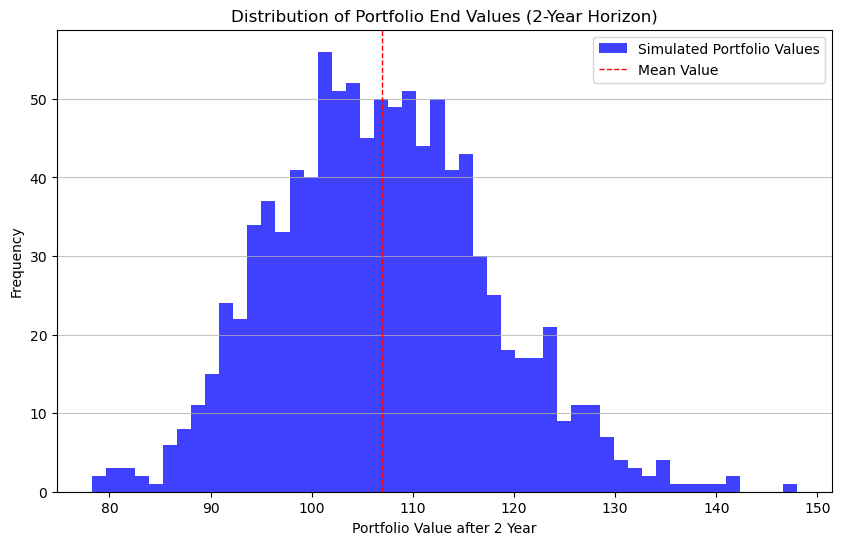

In [6]:
#ND: The Question prompt given to us is 
'''Simulate the optimal portfolio you solved in (1). 
Use the historical data from Dec-2018 to Dec-2021 to calculate the average return, variance and covariance of the portfolio components. 
	* Show the var-cov matrix
	* Run GBM simulations (with Cholesky decomposition) of the portfolio by using the parameters calculated. 
	   Simulation period: Jan-2022 to Jan-2024
	   Frequency (step size): Weekly
                  Number of Simulation Paths: 1000
	    Initial Portfolio Value: 100
'''
# Step 4: Simulate portfolio values using Geometric Brownian Motion (GBM)

# Parameters
num_simulations = 1000  # Number of simulations

#ND OLD: trading_days = 252  # Trading days in a year
weeks_to_simulate = 104  # 2 years, 52 weeks per year #ND- Updated from daily to weekly Simulation

initial_portfolio_value = 100  # Initial portfolio value #ND- old 10000 to new 100

# Cholesky decomposition of the covariance matrix
cholesky_decomp = np.linalg.cholesky(cov_matrix)

# Empty array to store the final portfolio values from each simulation
final_values = []

# Run simulations
for _ in range(num_simulations):
    # Simulate daily returns for each asset
    #ND COMMENTED LINE: daily_values = np.ones(trading_days) * initial_portfolio_value
    portfolio_value = initial_portfolio_value
    
    #for day in range(trading_days):  #ND OLD commented
    for week in range(weeks_to_simulate):
        # Generate random vector for correlated returns
        random_vector = np.random.normal(0, 1, len(tickers))
        correlated_returns = np.dot(cholesky_decomp, random_vector)
        
        # Calculate weekly return using mean and correlated random shock #ND: from daily to weekly
        weekly_return = np.dot(optimal_weights, mean_returns + correlated_returns) #ND: from daily to weekly
        
        # Update portfolio value using GBM formula
        portfolio_value *= np.exp(weekly_return) #ND: from daily to weekly
        #daily_values[day] = portfolio_value #ND: Commented
    
    # Store the end-of-simulation portfolio value
    final_values.append(portfolio_value)
  
# Step 5: Plot histogram of end values
plt.figure(figsize=(10, 6))

#ND-old no lable, added axvline
plt.hist(final_values, bins=50, alpha=0.75, color='blue', label='Simulated Portfolio Values')
plt.xlabel("Portfolio Value after 2 Year") #ND old 1 year
plt.ylabel("Frequency")
plt.title("Distribution of Portfolio End Values (2-Year Horizon)") #ND old 1 year

plt.grid(axis='y', alpha=0.75)  # Optional: Add grid for better visualization
plt.axvline(np.mean(final_values), color='red', linestyle='dashed', linewidth=1, label='Mean Value')  # Optional: Mean line
plt.legend()  # Optional: Show legend

plt.show()


In [7]:

#ND - Added
# Step : Calculate daily returns
returns = data.pct_change().dropna()

mean_returns = returns.mean()
cov_matrix = returns.cov()

# Display the mean returns
print("Mean Returns:")
print(mean_returns)

# Display the covariance matrix
print("\nCovariance Matrix:")
print(cov_matrix)

Mean Returns:
Ticker
C       0.000335
KO      0.000497
NFLX    0.000764
V       0.000383
XOM     0.001421
dtype: float64

Covariance Matrix:
Ticker         C        KO      NFLX         V       XOM
Ticker                                                  
C       0.000308  0.000045  0.000116  0.000103  0.000138
KO      0.000045  0.000095  0.000031  0.000057  0.000031
NFLX    0.000116  0.000031  0.000845  0.000136  0.000046
V       0.000103  0.000057  0.000136  0.000211  0.000062
XOM     0.000138  0.000031  0.000046  0.000062  0.000320


In [8]:
import numpy as np
import matplotlib.pyplot as plt

#ND-- Acual Returns are wrong for this, add code below to calculae Actual Returns below

# Set the actual 2024 YTD returns for each ETF
actual_returns = {
    'IAU': 0.000540,
    'VDE': 0.000279,
    'XLB': 0.000847,
    'DBC': 0.000480,
    'CQQQ': 0.000622
}


# Convert actual returns to an array and calculate the portfolio's actual return
actual_returns_array = np.array([actual_returns[ticker] for ticker in tickers])
portfolio_actual_return = np.dot(optimal_weights, actual_returns_array)

# Calculate the portfolio's actual end value after 1 year with initial investment of $10,000
initial_portfolio_value = 10000
actual_end_value = initial_portfolio_value * (1 + portfolio_actual_return)

# Plot histogram of simulated end values
plt.figure(figsize=(10, 6))
plt.hist(final_values, bins=50, alpha=0.75, color='blue', label='Simulated End Values')
plt.axvline(actual_end_value, color='red', linestyle='dashed', linewidth=2, label=f"Actual 2024 End Value: ${actual_end_value:.2f}")
plt.xlabel("Portfolio Value after 1 Year")
plt.ylabel("Frequency")
plt.title("Distribution of Portfolio End Values (1-Year Horizon) with Actual Return Overlay")
plt.legend()
plt.show()



KeyError: 'C'